In [1]:
%matplotlib inline 
%matplotlib nbagg
import lasagne
import theano
import theano.tensor as T
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from data_generator import get_batch, print_valid_characters


# Recurrent Neural Networks

Recurrent neural networks are the natural choice for sequential data i.e. time series analysis, translation, speech recognition, biological sequence analysis etc. Recurrent neural networks works by recursively applying the same operation at each time step of the data sequence and having layers that pass information from previous time steps to the current. It can therefore naturally handle input of varying length. Recurrent networks are used for several prediction tasks including: sequence-to-class, sequence tagging, and sequence-to-sequence predictions.

In this exercise we'll implement an Encoder-Decoder RNN build with the GRU unit. This type of models have shown impressive performance in Neural Machine Translation and Image Caption generation. 

For more in depth background material on RNNs please cf. [Supervised Sequence Labelling with Recurrent
Neural Networks](https://www.cs.toronto.edu/~graves/preprint.pdf) by Alex Graves.

We know that LSTMs and GRUs are difficult to understand. A very good non-mathematical introduction is [Chris Olahs blog](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) (All the posts are nice and cover various topics within machine-learning).

# Encoder-Decoder
In the encoder-decoder architecture, one RNN (blue) encodes the input and a second RNN (red) calculates the target values. One essential step is to let the encoder and decoder communicate. In the simplest approach you use the last hidden state of the encoder to initialize the decoder. Other approaches lets the decoder attend to different parts of the encoded input at different timesteps in the decoding process. 

<img src="files/enc-dec.png", width=400>

In our implementation we use a RNN with gated recurrent units (GRU) as encoder. We then use the last hidden state of the encoder ($h^{enc}_T$) as input to the decoder which is also a RNN with GRU units. 

### RNNs in Lasagne
Lasagne has implementations of LSTM and GRU units. Both layers assume that the input from the layer below have the shape **(Batch_size, seq_len, num_features)**. In this excercise we will use the GRU unit since it only stores a single hidden value per neuron (LSTMs stores two) and is approximately twice as fast.

As stated above we will implement an Encoder-Decoder model. The simplest way to do this is to encode the input sequence using the Encoder model. We will then use the last hidden state of the Encoder $h^{enc}_T$ as input to the decoder model, which then uses this information (simply a fixed length vector of numbers) to produce the targets. There is (at least) two ways to input $h^{enc}_T$ into the decoder

1. Repeatly use $h^{enc}_T$ as input to the Decoder at each decode time step
2. Intialize the decoder using $h^{enc}_T$ and run the decoder without any inputs

In this exercise we follow the first approach because it's easier to implement. To do this need to create a lasagne layer that takes $h^{enc}_T$ and repeat it *N_decode_step* times. Below is an implementation of the RepeatLayer. You don't need to know the exact way it works, however make sure that you understand that it takes an input of size *(Batch_size x num_units)* and produces an output of size *(Batch_size x n_decode_steps x num_units)*.


In [2]:
class RepeatLayer(lasagne.layers.Layer):
    def __init__(self, incoming, n, **kwargs):
        '''
        The input is expected to be a 2D tensor of shape 
        (num_batch, num_features). The input is repeated
        n times such that the output will be 
        (num_batch, n, num_features)
        '''
        super(RepeatLayer, self).__init__(incoming, **kwargs)
        self.n = n

    def get_output_shape_for(self, input_shape):
        return tuple([input_shape[0], self.n] + list(input_shape[1:]))

    def get_output_for(self, input, **kwargs):
        #repeat the input n times
        tensors = [input]*self.n
        stacked = theano.tensor.stack(*tensors)
        dim = [1, 0] + range(2, input.ndim + 1)
        return stacked.dimshuffle(dim)

### The Data
Since RNN models can be very slow to train on large datasets we will generate simpler training data for this exercise. The task for the RNN is simply to translate a string of letters spelling the numbers between 0-9 into the corresponding numbers i.e

"one two five" --> "125#" (we use # as a special end-of-sequence character)

To input the strings into the RNN model we translate the characters into a vector of integers using a simple translation table (i.e. 'h'->16, 'o'-> 17 etc). The code below prints a few input/output pairs using the *get_batch* function which randomly produces the data.

In [3]:
batch_size = 3
inputs, input_masks, targets, target_masks, text_inputs, text_targets = \
    get_batch(batch_size=batch_size,max_digits=2,min_digits=1)

print "input types:", inputs.dtype,  input_masks.dtype, targets.dtype, target_masks.dtype
print print_valid_characters()
print "Stop character = #"

for i in range(batch_size):
    print "\nSAMPLE",i
    print "TEXT INPUTS:\t\t", text_inputs[i]
    print "TEXT TARGETS:\t\t", text_targets[i]
    print "ENCODED INPUTS:\t\t", inputs[i]
    print "MASK INPUTS:\t\t", input_masks[i]
    print "ENCODED TARGETS:\t", targets[i]
    print "MASK TARGETS:\t\t", target_masks[i]

input types: int32 float32 int32 float32
Number of valid characters: 27
'0'=0,	'1'=1,	'2'=2,	'3'=3,	'4'=4,	'5'=5,	'6'=6,	'7'=7,	'8'=8,	'9'=9,	'#'=10,	' '=11,	'e'=12,	'g'=13,	'f'=14,	'i'=15,	'h'=16,	'o'=17,	'n'=18,	's'=19,	'r'=20,	'u'=21,	't'=22,	'w'=23,	'v'=24,	'x'=25,	'z'=26,	
None
Stop character = #

SAMPLE 0
TEXT INPUTS:		one zero
TEXT TARGETS:		10#
ENCODED INPUTS:		[17 18 12 11 26 12 20 17  0]
MASK INPUTS:		[ 1.  1.  1.  1.  1.  1.  1.  1.  0.]
ENCODED TARGETS:	[ 1  0 10]
MASK TARGETS:		[ 1.  1.  1.]

SAMPLE 1
TEXT INPUTS:		seven two
TEXT TARGETS:		72#
ENCODED INPUTS:		[19 12 24 12 18 11 22 23 17]
MASK INPUTS:		[ 1.  1.  1.  1.  1.  1.  1.  1.  1.]
ENCODED TARGETS:	[ 7  2 10]
MASK TARGETS:		[ 1.  1.  1.]

SAMPLE 2
TEXT INPUTS:		seven
TEXT TARGETS:		7#
ENCODED INPUTS:		[19 12 24 12 18  0  0  0  0]
MASK INPUTS:		[ 1.  1.  1.  1.  1.  0.  0.  0.  0.]
ENCODED TARGETS:	[ 7 10  0]
MASK TARGETS:		[ 1.  1.  0.]


### Encoder Decoder model setup
Below is the Lasagne model implementation. We use an embedding layer to map from integer to multinomial vector representation.

Note that the layer has a lot of print statements which we used for debugging during setup.

In [24]:
BATCH_SIZE = 100
NUM_UNITS_ENC = 10
NUM_UNITS_DEC = 10
MAX_DIGITS = 20 
MIN_DIGITS = MAX_DIGITS #currently only support for same length outputs - we'll leave it for an exercise to add support for varying length targets
NUM_INPUTS = 27
NUM_OUTPUTS = 11 #(0-9 + '#')


#symbolic theano variables. Note that we are using imatrix for X since it goes into the embedding layer
x_sym = T.imatrix()
y_sym = T.imatrix()
xmask_sym = T.matrix()

#dummy data to test implementation - We advise to check the output-dimensions of all layers.
#One way to do this in lasagne/theano is to forward pass some data through the model and 
#check the output dimensions of these.
#Create some random testdata
X = np.random.randint(0,10,size=(BATCH_SIZE,MIN_DIGITS)).astype('int32')
Xmask = np.ones((BATCH_SIZE,MIN_DIGITS)).astype('float32')

print(type(X))
print(X.shape)

##### ENCODER START #####
l_in = lasagne.layers.InputLayer((None, None))
l_emb = lasagne.layers.EmbeddingLayer(l_in, NUM_INPUTS, NUM_INPUTS, 
                                      W=np.eye(NUM_INPUTS,dtype='float32'),
                                      name='Embedding')
#Here we'll remove the trainable parameters from the embeding layer to constrain 
#it to a simple "one-hot-encoding". You can experiment with removing this line
l_emb.params[l_emb.W].remove('trainable') 
#forward pass some data throug the inputlayer-embedding layer and print the output shape
print lasagne.layers.get_output(l_emb, inputs={l_in: x_sym}).eval({x_sym: X}).shape

l_mask_enc = lasagne.layers.InputLayer((None, None))
l_enc = lasagne.layers.GRULayer(l_emb, num_units=NUM_UNITS_ENC, name='GRUEncoder', mask_input=l_mask_enc)
print lasagne.layers.get_output(l_enc, inputs={l_in: x_sym, l_mask_enc: xmask_sym}).eval(
    {x_sym: X, xmask_sym: Xmask}).shape

# slice last index of dimension 1
l_last_hid = lasagne.layers.SliceLayer(l_enc, indices=-1, axis=1)
print lasagne.layers.get_output(l_last_hid, inputs={l_in: x_sym, l_mask_enc: xmask_sym}).eval(
    {x_sym: X, xmask_sym: Xmask}).shape
##### END OF ENCODER######


##### START OF DECODER######
l_in_rep = RepeatLayer(l_last_hid, n=MAX_DIGITS+1) #we add one to allow space for the end of sequence character
print("Repeat layer")
print lasagne.layers.get_output(l_in_rep, inputs={l_in: x_sym, l_mask_enc: xmask_sym}).eval(
    {x_sym: X, xmask_sym: Xmask}).shape

l_dec = lasagne.layers.GRULayer(l_in_rep, num_units=NUM_UNITS_DEC, name='GRUDecoder')
print lasagne.layers.get_output(l_dec, inputs={l_in: x_sym, l_mask_enc: xmask_sym}).eval(
    {x_sym: X, xmask_sym: Xmask}).shape


# We need to do some reshape voodo to connect a softmax layer to the decoder.
# See http://lasagne.readthedocs.org/en/latest/modules/layers/recurrent.html#examples 
# In short this line changes the shape from 
# (batch_size, decode_len, num_dec_units) -> (batch_size*decodelen,num_dec_units). 
# We need to do this since the softmax is applied to the last dimension and we want to 
# softmax the output at each position individually
l_reshape = lasagne.layers.ReshapeLayer(l_dec, (-1, [2]))
print lasagne.layers.get_output(l_reshape, inputs={l_in: x_sym, l_mask_enc: xmask_sym}).eval(
    {x_sym: X, xmask_sym: Xmask}).shape

l_softmax = lasagne.layers.DenseLayer(l_reshape, num_units=NUM_OUTPUTS, 
                                      nonlinearity=lasagne.nonlinearities.softmax,
                                      name='SoftmaxOutput')
print lasagne.layers.get_output(l_softmax, inputs={l_in: x_sym, l_mask_enc: xmask_sym}).eval(
    {x_sym: X, xmask_sym: Xmask}).shape

# reshape back to 3d format (batch_size, decode_len, num_dec_units). Here we tied the batch size to the shape of the symbolic variable for X allowing 
#us to use different batch sizes in the model.
l_out = lasagne.layers.ReshapeLayer(l_softmax, (x_sym.shape[0], -1, NUM_OUTPUTS))
print lasagne.layers.get_output(l_out, inputs={l_in: x_sym, l_mask_enc: xmask_sym}).eval(
    {x_sym: X, xmask_sym: Xmask}).shape
###END OF DECODER######

<type 'numpy.ndarray'>
(100, 20)
(100, 20, 27)
(100, 20, 10)
(100, 10)
Repeat layer
(100, 21, 10)
(100, 21, 10)
(2100, 10)
(2100, 11)
(100, 21, 11)


### Defining the cost function and theano functions
The targets are categorical, hence we use cross entropy error. We use the Adam optimizer but you
can experiment with the different optimizers implemented in [Lasagne](http://lasagne.readthedocs.org/en/latest/modules/updates.html). 

In [25]:
output_decoder_train = lasagne.layers.get_output(l_out, inputs={l_in: x_sym, l_mask_enc: xmask_sym}, 
                                                deterministic=False)

#cost function
total_cost = T.nnet.categorical_crossentropy(
    T.reshape(output_decoder_train, (-1, NUM_OUTPUTS)), y_sym.flatten())
mean_cost = T.mean(total_cost)
#accuracy function
argmax = T.argmax(output_decoder_train,axis=-1)
eq = T.eq(argmax,y_sym)
acc = T.mean(eq)  # gives float64 because eq is uint8, T.cast(eq, 'float32') will fix that...

#Get parameters of both encoder and decoder
all_parameters = lasagne.layers.get_all_params([l_out], trainable=True)

print "Trainable Model Parameters"
print "-"*40
for param in all_parameters:
    print param, param.get_value().shape
print "-"*40

#add grad clipping to avoid exploding gradients
all_grads = [T.clip(g,-3,3) for g in T.grad(mean_cost, all_parameters)]
all_grads = lasagne.updates.total_norm_constraint(all_grads,3)

#Compile Theano functions.
updates = lasagne.updates.adam(all_grads, all_parameters, learning_rate=0.005)
train_func = theano.function([x_sym, y_sym, xmask_sym], [mean_cost, acc, output_decoder_train, argmax, eq], updates=updates)
#since we don't have any stochasticity in the network we will just use the training graph without any updates given
test_func = theano.function([x_sym, y_sym, xmask_sym], [acc, output_decoder_train])

Trainable Model Parameters
----------------------------------------
GRUEncoder.W_in_to_updategate (27, 10)
GRUEncoder.W_hid_to_updategate (10, 10)
GRUEncoder.b_updategate (10,)
GRUEncoder.W_in_to_resetgate (27, 10)
GRUEncoder.W_hid_to_resetgate (10, 10)
GRUEncoder.b_resetgate (10,)
GRUEncoder.W_in_to_hidden_update (27, 10)
GRUEncoder.W_hid_to_hidden_update (10, 10)
GRUEncoder.b_hidden_update (10,)
GRUDecoder.W_in_to_updategate (10, 10)
GRUDecoder.W_hid_to_updategate (10, 10)
GRUDecoder.b_updategate (10,)
GRUDecoder.W_in_to_resetgate (10, 10)
GRUDecoder.W_hid_to_resetgate (10, 10)
GRUDecoder.b_resetgate (10,)
GRUDecoder.W_in_to_hidden_update (10, 10)
GRUDecoder.W_hid_to_hidden_update (10, 10)
GRUDecoder.b_hidden_update (10,)
SoftmaxOutput.W (10, 11)
SoftmaxOutput.b (11,)
----------------------------------------


In [26]:
#Generate validation data
Xval, Xmask_val, Yval, Ymask_val, text_inputs_val, text_targets_val = \
    get_batch(batch_size=5000, max_digits=MAX_DIGITS,min_digits=MIN_DIGITS)
print "Xval", Xval.shape
print "Yval", Yval.shape

Xval (5000, 111)
Yval (5000, 21)


# Training

In [27]:
val_interval = 5000
samples_to_process = 3e5
samples_processed = 0

val_samples = []
costs, accs = [], []
plt.figure()
try:
    while samples_processed < samples_to_process:
        x_, x_masks_, ys_, y_masks_, _, _ = \
            get_batch(batch_size=BATCH_SIZE,max_digits=MAX_DIGITS,min_digits=MIN_DIGITS)
        print("Y shape:")
        print(ys_.shape)
#         print(ys_.flatten().shape)
        batch_cost, batch_acc, batch_output, batch_argmax, batch_eq = train_func(x_, ys_, x_masks_)
        print("Output shape:")
        print(batch_output.shape)
        print("Argmax shape:")
        print(batch_argmax.shape)
        print("Eq shape:")
        print(batch_eq.shape)
        costs += [batch_cost]
        samples_processed += BATCH_SIZE
        #validation data
        if samples_processed % val_interval == 0:
            #print "validating"
            val_acc, val_output = test_func(Xval, Yval, Xmask_val)
            val_samples += [samples_processed]
            accs += [val_acc]
            plt.plot(val_samples,accs)
            plt.ylabel('Validation Accuracy', fontsize=15)
            plt.xlabel('Processed samples', fontsize=15)
            plt.title('', fontsize=20)
            plt.grid('on')
            plt.savefig("out.png")
            display.display(display.Image(filename="out.png"))
            display.clear_output(wait=True)
except KeyboardInterrupt:
    pass    

Y shape:
(100, 21)
Output shape:
(100, 21, 11)
Argmax shape:
(100, 21)
Eq shape:
(100, 21)
Y shape:
(100, 21)
Output shape:
(100, 21, 11)
Argmax shape:
(100, 21)
Eq shape:
(100, 21)
Y shape:
(100, 21)
Output shape:
(100, 21, 11)
Argmax shape:
(100, 21)
Eq shape:
(100, 21)
Y shape:
(100, 21)
Output shape:
(100, 21, 11)
Argmax shape:
(100, 21)
Eq shape:
(100, 21)
Y shape:
(100, 21)
Output shape:
(100, 21, 11)
Argmax shape:
(100, 21)
Eq shape:
(100, 21)
Y shape:
(100, 21)
Output shape:
(100, 21, 11)
Argmax shape:
(100, 21)
Eq shape:
(100, 21)
Y shape:
(100, 21)
Output shape:
(100, 21, 11)
Argmax shape:
(100, 21)
Eq shape:
(100, 21)
Y shape:
(100, 21)
Output shape:
(100, 21, 11)
Argmax shape:
(100, 21)
Eq shape:
(100, 21)
Y shape:
(100, 21)
Output shape:
(100, 21, 11)
Argmax shape:
(100, 21)
Eq shape:
(100, 21)
Y shape:
(100, 21)
Output shape:
(100, 21, 11)
Argmax shape:
(100, 21)
Eq shape:
(100, 21)
Y shape:
(100, 21)


In [8]:
#plot of validation accuracy for each target position
plt.figure(figsize=(7,7))
plt.plot(np.mean(np.argmax(val_output,axis=2)==Yval,axis=0))
plt.ylabel('Accuracy', fontsize=15)
plt.xlabel('Target position', fontsize=15)
#plt.title('', fontsize=20)
plt.grid('on')
plt.show()
#why do the plots look like this? See exercise 4 below.

<IPython.core.display.Javascript object>

In [9]:
# plot training cost
#plt.figure(figsize=(7,7))
#plt.plot(costs)
#plt.ylabel('Cost', fontsize=15)
#plt.xlabel('Number of updates', fontsize=15)
#plt.title('Training', fontsize=20)
#plt.show()

In [10]:
### Added to test the output
batch_size = 1
inputs, input_masks, targets, target_masks, text_inputs, text_targets = \
    get_batch(batch_size=batch_size,max_digits=MAX_DIGITS,min_digits=MIN_DIGITS)
    
# test_func = theano.function([x_sym, y_sym, xmask_sym], [acc, output_decoder_train])
    
# Xval, Xmask_val, Yval, Ymask_val, text_inputs_val, text_targets_val = \
#     get_batch(batch_size=5000, max_digits=MAX_DIGITS,min_digits=MIN_DIGITS)

# print "input types:", inputs.dtype,  input_masks.dtype, targets.dtype, target_masks.dtype
# print print_valid_characters()
# print "Stop character = #"

for i in range(batch_size):
#     print "\nSAMPLE",i
    print "TEXT INPUTS:\t\t", text_inputs[i]
    print "TEXT TARGETS:\t\t", text_targets[i]
#     print "ENCODED INPUTS:\t\t", inputs[i]
#     print "MASK INPUTS:\t\t", input_masks[i]
#     print "ENCODED TARGETS:\t", targets[i]
#     print "MASK TARGETS:\t\t", target_masks[i]

val_acc, val_output = test_func(inputs, targets, input_masks)

print("RESULTS:")

prediction = ""
for digit in val_output:
    for out in digit:
#         print(out)
        idx = np.argmax(out)
        if idx == NUM_OUTPUTS - 1:
            idx = '#'
        prediction += str(idx)

print(prediction)

TEXT INPUTS:		six two four zero eight two one four zero seven five five nine one nine five eight seven eight seven
TEXT TARGETS:		62408214075591958787#
RESULTS:
555555555555555555###


# Exercises:
1. Perform an explorative test of the network by inputting a defined input and evaulate the outputs.
2. The model has two GRU networks. The ```GRUEncoder``` and the ```GRUDecoder```. A GRU is parameterized by the  ```{W_in_to_updategate, W_hid_to_updategate, b_updategate, W_in_to_resetgate, W_hid_to_resetgate, b_resetgate,
W_in_to_hidden_update, W_hid_to_hidden_update,b_hidden_update}```. Try to explain the shape of ```W_in_to_updategate``` and ```hid_to_updategate```. Why are they different? You can find the equations for the gru at: [GRU](http://lasagne.readthedocs.io/en/latest/modules/layers/recurrent.html#lasagne.layers.GRULayer). 
3. The GRU unit is able to ignore the input and just copy the previous hidden state. In the beginning of training this might be desireable behavior, since it helps the model learn long range dependencies. You can make the model ignore the input by modifying initial bias values. What bias would you modify and how would you modify it? Again you'll need to refer to the GRU equations:  [GRU](http://lasagne.readthedocs.io/en/latest/modules/layers/recurrent.html#lasagne.layers.GRULayer).

4. What is the final validation performance? Why do you think it is not better? Comment on the accuracy for each position in of the output symbols?

5. Why do you think the validation performance looks more "jig-saw"-like compared to FFNN and CNN models?

6. In the example we stack a softmax layer on top of a Recurrent layer. In the code snippet below explain how we can do that?

# Answers:
## 1) 
I just get a random example from get_batch with a batch size of 1, insted of hard-coding a single example (see just above). There seems to be a trend for the results, so it didn't seem necessary to use just one fixed input.

What I see is that the network is pretty bad and has a tendency to predict the same digits several times in a row.

## 2)
They are weights for the input from the previous hidden layer, and for the recurrent layer at earlier time-steps respectively. As the number of inputs is different from the number of units in the recurrent layer, the shapes of the two weight-vectors are different.

## 3)
I would make $b_u$, used to calculate $u_t$, increadibly small. Since this adjusts the input to the sigmoid function, the result of the sigmoid operation will be ~0, which in turn results in the unit ignoring input from the previous layer (at current time) and using the values from the previous time-step.

## 4)
The accuracy is just above 15%, but goes to 100% for the last position, as it always gets the end-of-line character correct. I assume it is this bad because it has not properly learned when to use prior results and when to use new input, hence we see the same digit often being repeated in the output.

## 5)
I believe it is because of the GRU memory units, and the fact that they will at some point "discard/forget" a previous input in favor of a new input from the current time-step. Even though they are not discrete units that use one value or the other, I imagine that these changes could result in jumps in the output.

As I do not fully understand what the question is referring to I will just note that the jaggedness of the validation graph we see while training comes from the fact that we only plot it for every 5000 training examples, running on a total of 300000 exemples, many more than for previous networks we have trained.

## 6)
See comments below

In [11]:
### Store the dimensions of the recurrent layer to return to that shape later
bs_, seqlen_, numinputs_ = 16, 140, 40 
l_input_ = lasagne.layers.InputLayer((bs_, seqlen_, numinputs_))
l_gru_ = lasagne.layers.GRULayer(l_input_, num_units=10)
### We reshape/flatten the recurrent layer to simulate a standard dense layer.
### We do this to allow the softmax layer access to the activations from the GRU layer
l_reshape_ = lasagne.layers.ReshapeLayer(l_gru_, (-1, [2])) # the [2] tells lasagne to use the dim of the 2. 
                                                            # dim of the input here. -1 is a wildcard

### We map from 10 to 11 units to include the end of input character. 
### The 10 first units will map directly to the input, and the last that is not needed will have a high 
### activation when the others are low due to softmax summing to 1, which makes it represent end-of-sequence.
l_softmax_ = lasagne.layers.DenseLayer(l_reshape_, num_units=11, 
                                      nonlinearity=lasagne.nonlinearities.softmax)
### Reshape to return to recurrent structure
l_softmax_seq_ = lasagne.layers.ReshapeLayer(l_softmax_,(bs_, seqlen_, -1))
print "l_input_", l_input_.output_shape
print "l_gru_", l_gru_.output_shape
print "l_reshape_", l_reshape_.output_shape
print "l_softmax_", l_softmax_.output_shape
print "l_softmax_seq_", l_softmax_seq_.output_shape

l_input_ (16, 140, 40)
l_gru_ (16, 140, 10)
l_reshape_ (2240, 10)
l_softmax_ (2240, 11)
l_softmax_seq_ (16, 140, 11)


6. Optional: If you are interested in doing sentiment analysis on tweets, i.e classification as positive or negative. Use RNN to read over the twitter seqeuence and use the last hidden state to do the classification. How can you modify the small network above to only output binary classification? Hints: Look at the SliceLayer or the GRU docs...
7. Optional: Bidirectional Encoder, In Lasagne, bidirectional RNNs are implementated by running a forward model and a backward model separately and then concatenating them before parsing them to the next layer. You can experiment with using a different merging layer than concat e.g. sum or multiplication see [lasagne merge layers [lasagne merge layers](http://lasagne.readthedocs.org/en/latest/modules/layers/merge.html).
```
l_rec_fwd = lasagne.layers.GRULayer(...,backwards=False)
l_rec_bwd = lasagne.layers.GRULayer(...,backwards=True)
l_rec = lasagne.layers.ConcatLayer([l_rec_fwd, l_rec_bwd], axis=2))
```
8. Optional: Add support for different lengths of targets (hint: add the target_mask to the cost function and only calculate the cost for the non-masked targets)

## Attention Decoder (LSTM)
Selective attention for recurrent neural networks have recently attracted a lot of interest. These methods let the Decoder model selectively focus on which sub-sequence of the encoder sequence it will use for each decoded output symbol. This relieves the encoder from having to compress the input sequence into a fixed size vector representation. Secondly, we can investigate which part of the input that the decoder network emphazises. Below we'll implement an LSTM-decoder with selective attention and show that it significantly improves the performance of the toy translation task.

The attention paper is found here: https://arxiv.org/pdf/1409.0473v7.pdf.

The principles of the attention model are simple. 

1. Use the encoder to get the hidden represention $\{h^1_e, ...h^n_e\}$ for each position in the input sequence. 
2. For timestep $t$ in the decoder $m = 1...n$ : $a_m = f(h^m_e, h^d_t)$. Where f is a function returning a scalar value.
3. You can then normalize the sequence of scalars $\{a_1, ... a_n\}$ to get probablities $\{p_1, ... p_n\}$.
4. Weigh each $h^e_t$ by its probablity $p_t$ and sum to get $h_{in}$.
5. Use $h_{in}$ as an additional input to the decoder. $h_{in}$ is recalculated each time the decoder is updated.

In [12]:
from decoder_attention import LSTMAttentionDecodeFeedbackLayer

# you can acces the attetion weights alpha by adding l_dec.alpha 
# to the output variables in the theano function

BATCH_SIZE = 100
NUM_UNITS_ENC = 10
NUM_UNITS_DEC = 10
MAX_DIGITS = 20 
MIN_DIGITS = MAX_DIGITS #currently only support for same length outputs - we'll leave it for an exercise to add support for varying length targets
NUM_INPUTS = 27
NUM_OUTPUTS = 11 #(0-9 + '#')


x_sym = T.imatrix()
y_sym = T.imatrix()
xmask_sym = T.matrix()
    

#dummy data to test implementation
#X = np.random.randint(0,10,size=(BATCH_SIZE,15)).astype('int32')
#Xmask = np.ones((BATCH_SIZE,NUM_INPUTS)).astype('float32')

l_in = lasagne.layers.InputLayer((None, None))
l_emb = lasagne.layers.EmbeddingLayer(l_in, NUM_INPUTS, NUM_INPUTS, 
                                      W=np.eye(NUM_INPUTS,dtype='float32'),
                                      name='Embedding')
##### ENCODER START #####
l_in = lasagne.layers.InputLayer((None, None))
l_emb = lasagne.layers.EmbeddingLayer(l_in, NUM_INPUTS, NUM_INPUTS, 
                                      W=np.eye(NUM_INPUTS,dtype='float32'),
                                      name='Embedding')
#Here we'll remove the trainable parameters from the embeding layer to constrain 
#it to a simple "one-hot-encoding". You can experiment with removing this line
l_emb.params[l_emb.W].remove('trainable') 
print lasagne.layers.get_output(l_emb, inputs={l_in: x_sym}).eval(
    {x_sym: X}).shape
T.grad(lasagne.layers.get_output(l_emb, inputs={l_in: x_sym}).sum(), 
       lasagne.layers.get_all_params(l_emb, trainable=True))




l_mask_enc = lasagne.layers.InputLayer((None, None))
l_enc = lasagne.layers.GRULayer(l_emb, num_units=NUM_UNITS_ENC, name='GRUEncoder', mask_input=l_mask_enc)
print lasagne.layers.get_output(l_enc, inputs={l_in: x_sym, l_mask_enc: xmask_sym}).eval(
    {x_sym: X, xmask_sym: Xmask}).shape
T.grad(lasagne.layers.get_output(l_enc, inputs={l_in: x_sym, l_mask_enc: xmask_sym}).sum(), 
       lasagne.layers.get_all_params(l_enc, trainable=True))
####END OF ENCODER######


####START OF DECODER######
#note that the decoder have its own input layer, we'll use that to plug in the output 
#from the encoder later
l_dec = LSTMAttentionDecodeFeedbackLayer(l_enc,
                                        num_units=NUM_UNITS_DEC, 
                                        aln_num_units=20,
                                        n_decodesteps=MAX_DIGITS+1,
                                        name='LSTMDecoder')
print lasagne.layers.get_output(l_dec, inputs={l_in: x_sym, l_mask_enc: xmask_sym}).eval(
    {x_sym: X, xmask_sym: Xmask}).shape
T.grad(lasagne.layers.get_output(l_dec, inputs={l_in: x_sym, l_mask_enc: xmask_sym}).sum(), 
       lasagne.layers.get_all_params(l_dec, trainable=True))

# We need to do some reshape voodo to connect a softmax layer to the decoder.
# See http://lasagne.readthedocs.org/en/latest/modules/layers/recurrent.html#examples 
l_reshape = lasagne.layers.ReshapeLayer(l_dec, (-1, [2]))
l_softmax = lasagne.layers.DenseLayer(l_reshape, num_units=NUM_OUTPUTS, 
                                      nonlinearity=lasagne.nonlinearities.softmax,
                                      name='SoftmaxOutput')
# print lasagne.layers.get_output(l_softmax, x_sym).eval({x_sym: X}).shape
# reshape back to 3d format (here we tied the batch size to the shape of the symbolic variable for X allowing 
#us to use different batch sizes in the model)
l_out = lasagne.layers.ReshapeLayer(l_softmax, (x_sym.shape[0], -1, NUM_OUTPUTS))
print lasagne.layers.get_output(l_out, inputs={l_in: x_sym, l_mask_enc: xmask_sym}, deterministic=False).eval(
    {x_sym: X, xmask_sym: Xmask}).shape
T.grad(lasagne.layers.get_output(l_out, inputs={l_in: x_sym, l_mask_enc: xmask_sym}).sum(), 
       lasagne.layers.get_all_params(l_dec, trainable=True))

print ""
###END OF DECODER######



(100, 20, 27)
(100, 20, 10)
(100, 21, 10)
(100, 21, 11)



In [13]:
#Generate some validation data
Xval, Xmask_val, Yval, Ymask_val, text_inputs_val, text_targets_val = \
    get_batch(batch_size=5000, max_digits=MAX_DIGITS,min_digits=MIN_DIGITS)

In [ ]:
#get output of encoder using X and Xmask as input
output_decoder_train = lasagne.layers.get_output(l_out, inputs={l_in: x_sym, l_mask_enc: xmask_sym}, 
                                                 deterministic=False)

#cost function
total_cost = T.nnet.categorical_crossentropy(
    T.reshape(output_decoder_train, (-1, NUM_OUTPUTS)), y_sym.flatten())
mean_cost = T.mean(total_cost)
#accuracy function
acc = T.mean(T.eq(T.argmax(output_decoder_train,axis=-1),y_sym))

#Get parameters of both encoder and decoder
all_parameters = lasagne.layers.get_all_params(l_out, trainable=True)

print "Trainable Model Parameters"
print "-"*40
for param in all_parameters:
    print param, param.get_value().shape
print "-"*40

#add grad clipping to avoid exploding gradients
all_grads = [T.clip(g,-3,3) for g in T.grad(mean_cost, all_parameters)]
all_grads = lasagne.updates.total_norm_constraint(all_grads,3)

#Compile Theano functions
updates = lasagne.updates.adam(all_grads, all_parameters, learning_rate=0.005)
train_func = theano.function([x_sym, y_sym, xmask_sym], [mean_cost, acc, output_decoder_train], updates=updates)
#since we don't have any stochasticity in the network we will just use the training graph without any updates given
test_func = theano.function([x_sym, y_sym, xmask_sym], [acc, output_decoder_train, l_dec.alpha])


Trainable Model Parameters
----------------------------------------
GRUEncoder.W_in_to_updategate (27, 10)
GRUEncoder.W_hid_to_updategate (10, 10)
GRUEncoder.b_updategate (10,)
GRUEncoder.W_in_to_resetgate (27, 10)
GRUEncoder.W_hid_to_resetgate (10, 10)
GRUEncoder.b_resetgate (10,)
GRUEncoder.W_in_to_hidden_update (27, 10)
GRUEncoder.W_hid_to_hidden_update (10, 10)
GRUEncoder.b_hidden_update (10,)
LSTMDecoder.W_hid_to_ingate (10, 10)
LSTMDecoder.b_ingate (10,)
LSTMDecoder.W_hid_to_forgetgate (10, 10)
LSTMDecoder.b_forgetgate (10,)
LSTMDecoder.W_hid_to_cell (10, 10)
LSTMDecoder.b_cell (10,)
LSTMDecoder.W_hid_to_outgate (10, 10)
LSTMDecoder.b_outgate (10,)
LSTMDecoder.W_weightedhid_to_ingate (10, 10)
LSTMDecoder.W_weightedhid_to_forgetgate (10, 10)
LSTMDecoder.W_weightedhid_to_cell (10, 10)
LSTMDecoder.W_weightedhid_to_outgate (10, 10)
LSTMDecoder.W_cell_to_ingate (10,)
LSTMDecoder.W_cell_to_forgetgate (10,)
LSTMDecoder.W_cell_to_outgate (10,)
LSTMDecoder.AlignSeqOutputLayer: (aln) W_a (

ERROR (theano.gof.opt): Optimization failure due to: local_reshape_dimshuffle
ERROR (theano.gof.opt): node: Reshape{2}(InplaceDimShuffle{0,x}.0, <TensorType(int64, vector)>)
ERROR (theano.gof.opt): TRACEBACK:
ERROR (theano.gof.opt): Traceback (most recent call last):
  File "/home/nch/anaconda2/lib/python2.7/site-packages/theano/gof/opt.py", line 1922, in process_node
    replacements = lopt.transform(node)
  File "/home/nch/anaconda2/lib/python2.7/site-packages/theano/tensor/opt_uncanonicalize.py", line 147, in local_reshape_dimshuffle
    return [T.reshape(input_.owner.inputs[0], node.inputs[1])]
  File "/home/nch/anaconda2/lib/python2.7/site-packages/theano/tensor/basic.py", line 4683, in reshape
    "argument to 'reshape' to avoid this problem." % newshape)
ValueError: The length of the provided shape (<TensorType(int64, vector)>) cannot be automatically determined, so Theano is not able to know what the number of dimensions of the reshaped variable will be. You can provide the 'nd

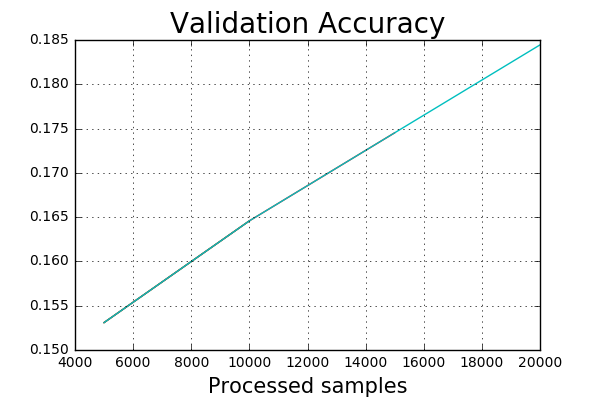

In [ ]:
val_interval = 5000
samples_to_process = 1.5e5
samples_processed = 0
val_samples = []
costs, accs = [], []
plt.figure()
try:
    while samples_processed < samples_to_process:
        inputs, input_masks, targets, target_masks, _, _ = \
            get_batch(batch_size=BATCH_SIZE,max_digits=MAX_DIGITS,min_digits=MIN_DIGITS)
        batch_cost, batch_acc, batch_output = train_func(inputs, targets, input_masks)
        costs += [batch_cost]
        samples_processed += BATCH_SIZE
        if samples_processed % val_interval == 0:
            #print "validating"
            val_acc, val_output, alpha = test_func(Xval, Yval, Xmask_val)
            val_samples += [samples_processed]
            accs += [val_acc]
            plt.plot(val_samples,accs)
            plt.ylabel('', fontsize=15)
            plt.xlabel('Processed samples', fontsize=15)
            plt.title('Validation Accuracy', fontsize=20)
            plt.grid('on')
            plt.savefig("out.png")
            display.display(display.Image(filename="out.png"))
            display.clear_output(wait=True)
except KeyboardInterrupt:
    pass
        

In [ ]:
#plot of validation accuracy for each target position
plt.figure(figsize=(7,7))
plt.plot(np.mean(np.argmax(val_output,axis=2)==Yval,axis=0))
plt.ylabel('Accuracy', fontsize=15)
plt.xlabel('Target position', fontsize=15)
#plt.title('', fontsize=20)
plt.grid('on')
plt.show()
#why do the plot look like this?
### The network is still bad at predicting the later parts of the input.
### This is because the input will diverge more and more from the learned attentions the further we get

In [ ]:
#Plot of average attention weight as a function of the sequence position for each of 
#the 21 targets in the output sequence i.e. each line is the mean postion of the 
#attention for each target position.

np.mean(alpha,axis=0).shape
plt.figure()
plt.plot(np.mean(alpha,axis=0).T)
plt.ylabel('alpha', fontsize=15)
plt.xlabel('Input Sequence position', fontsize=15)
plt.title('Alpha weights', fontsize=20)
plt.legend(map(str,range(1,22)), bbox_to_anchor=(1.125,1.0), fontsize=10)
plt.show()


## Assignments for the attention decoder
1. Explain what the alpha weights show. 
2. Why are the alpha curve for the first digit narrow and peaked while later digits have alpha curves that are wider and less peaked?
3. Why is attention a good idea for this problem? Can you think of other problems where attention is a good choice?

## Answers
### 1)
The alpha weights are a visualization of the attention given to calculate the $i$th output digit, based on how far you are in the input sequence. 

### 2)
The first digit can only appear in the first part of the input sequence. It has a length within a fixed range (which depends on the number of letters used to spell each number used in the training data), and so we are always relatively sure where to find it, so we want to pay close attention to that part of the sequence for that digit. For each consecutive digit we become more unsure of the position interval the digit will appear in, and so we have to spread our attention out more to find it. This is of course because each digit takes up a varying part of the input sequence, so for each digit we process we offset the start of the next digit by more.

### 3)
Attention is a good idea for this problem because the network has to learn that the input consists of small chunks of data, which have to be interpreted separately. Attention greatly helps to learn in which areas of the inputs the borders between digits will be.